# Fitting Tutorial

Below is a basic exercise in fitting a quadratic polynomial to some noisy data, done using many different fitting packages to demonstrate their basic usage.

$$
\chi^2 = \sum_i^n \frac{(x_{i, \rm true} - x_{i, \rm model})^2}{\sigma_{x_i}^2}
$$

Reduced $\chi^2$:
$$
\chi^2_r = \chi^2/(n - {\rm len} \theta)
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

## The True Model (and Data Generation)

In [2]:
def model(x, a, b, c):
    '''The model we are fitting.'''
    return a*x**2 + b*x + c

x = np.linspace(-5, 5, 256)
SIG_N = 1
prms_true = (1.1, 2.2, 3.3)
y_meas = model(x, *prms_true) + SIG_N * np.random.normal(size=x.shape)

In [3]:
def report(prms):
    '''Generate a pretty report and plot for a set of parameters.'''
    if type(prms) == dict:
        prms = (prms['a'], prms['b'], prms['c'])
    if type(prms[0]) != float:
        prms = tuple(float(p) for p in prms)
    y = model(x, *prms)
    chisq = np.sum(np.abs(y_meas - y)**2 / SIG_N**2)
    chisq_r = chisq / (y_meas.size - len(prms))
    print(f'A:{prms[0]:7.3}, B:{prms[1]:7.3}, C:{prms[2]:7.3}')
    print(f'Chi-sq: {chisq:7.3}, Reduced Chi-sq: {chisq_r:7.3}')

    plt.figure()
    plt.plot(x, y_meas, '.', label='measured')
    plt.plot(x, y, label='model')
    plt.plot(x, y_meas - y, label='residual')
    plt.grid()
    _ = plt.legend()

A:    1.1, B:    2.2, C:    3.3
Chi-sq: 2.5e+02, Reduced Chi-sq:   0.988


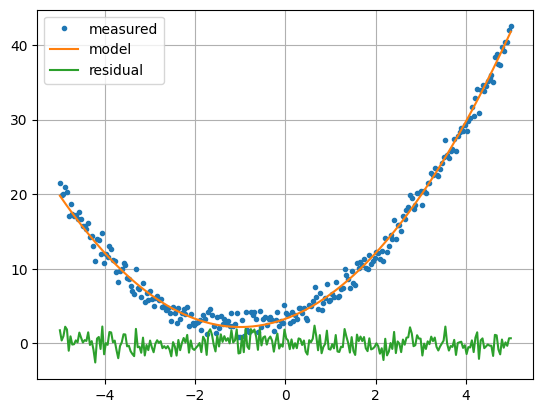

In [4]:
report(prms_true)

# Fitting with pymc

In [5]:
import corner
import tqdm

prm_order = ['a', 'b', 'c', 'logsig']
nprms = len(prm_order)

## pymc

<tt>pymc</tt> is a relatively batteries-included MCMC package. Running it is pretty simple, but beware that the way a chain is set up relies implicitly on class instantiation, making its evaluation a little hard for a reader to follow. 

In [6]:
import pymc

def run_mcmc(x, y_meas):
    with pymc.Model() as mdl:
        a = pymc.Uniform('a', -5, 5)
        b = pymc.Uniform('b', -5, 5)
        c = pymc.Uniform('c', -5, 5)
        logsig = pymc.Uniform('logsig', -1.0, 1.0)
        y_err = 10**logsig
        yhat = model(x, a, b, c)
        pymc.Normal("y", mu=yhat, sigma=y_err, observed=y_meas)
        return pymc.sample(draws=2_000, tune=200, cores=4)

chain = run_mcmc(x, y_meas)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, logsig]


Sampling 4 chains for 200 tune and 2_000 draw iterations (800 + 8_000 draws total) took 6 seconds.


Text(0.5, 0, 'Step')

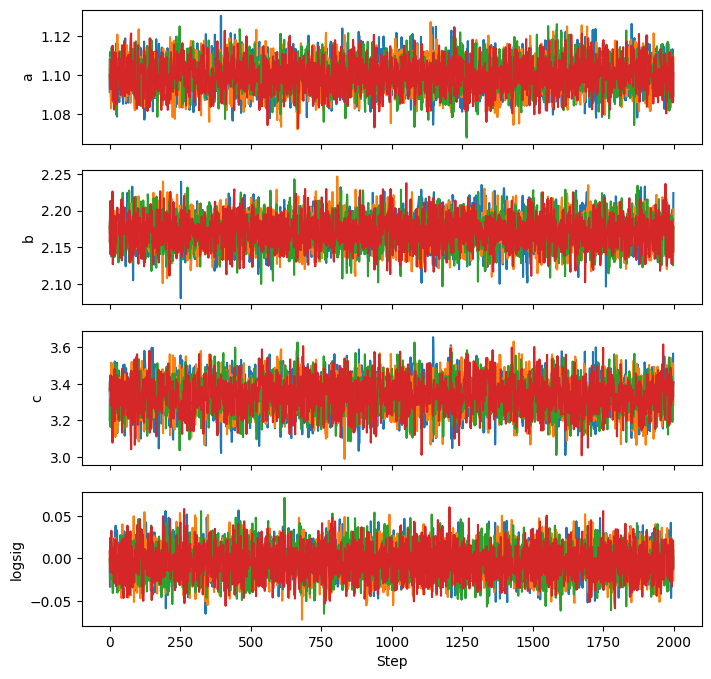

In [7]:
fig, axes = plt.subplots(nrows=nprms, sharex=True, figsize=(8,8))
for i, k in enumerate(prm_order):
    axes[i].plot(chain.posterior[k].T)
    axes[i].set_ylabel(k)
axes[nprms-1].set_xlabel('Step')

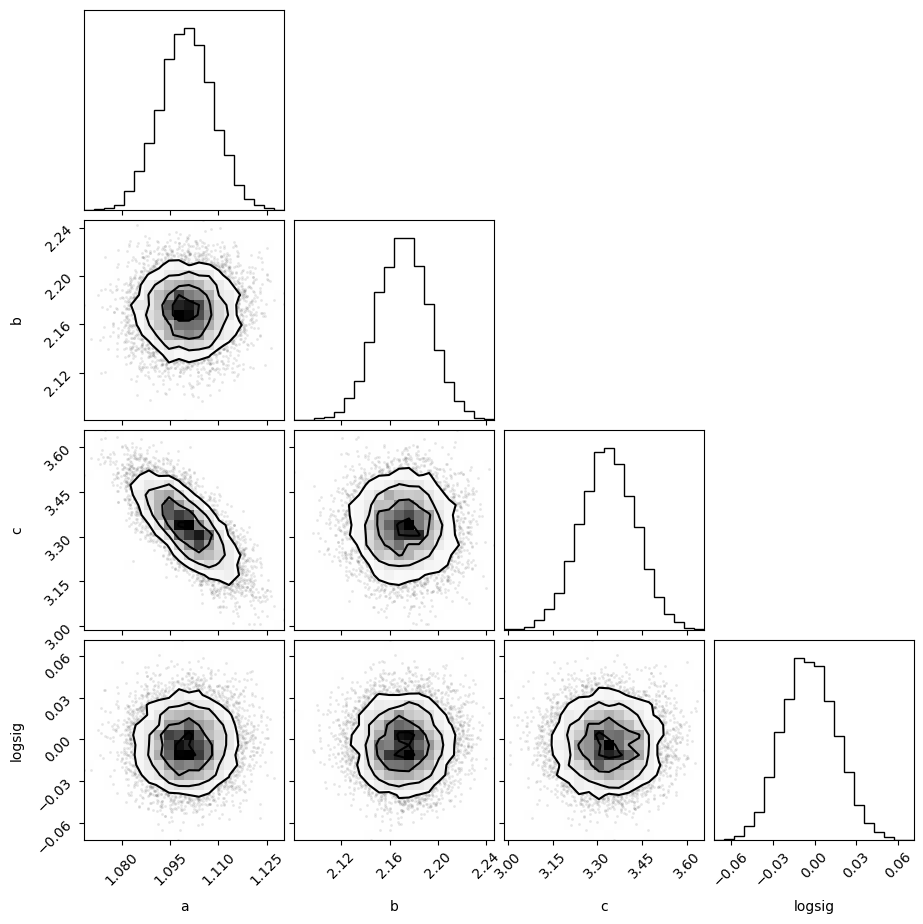

In [8]:
_ = corner.corner(chain)

Inferred noise sigma:   0.992
A:    1.1, B:   2.17, C:   3.33
Chi-sq: 2.48e+02, Reduced Chi-sq:    0.98


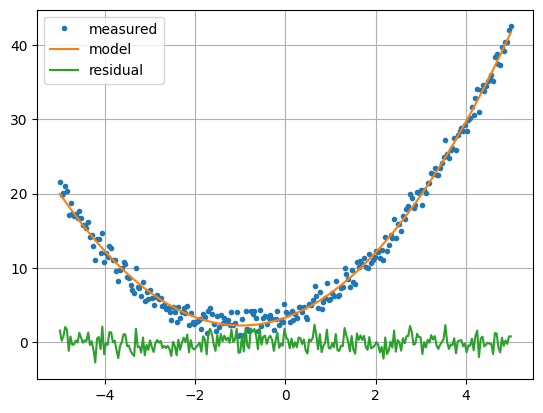

In [9]:
prms_opt = {k: np.mean(chain.posterior[k]) for k in prm_order}
sig_n = 10**prms_opt.pop('logsig')
print(f'Inferred noise sigma: {sig_n:7.3}')
report(prms_opt)